## High Level Computer Vision 
### Exercise 2: Deep Neural Networks and Backpropagation

In [1]:
Name = "Luisa Danalachi"
Matriculation_Number = "7022909"

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
from resources.data_utils import get_CIFAR10_data
from resources.vis_utils import visualize_grid

Deep neural networks have shown staggering performances in various learning tasks, including computer vision, natural language processing, and sound processing. They have made the model design more flexible by enabling end-to-end training.

In this exercise, we get to have a first hands-on experience with neural network training. Many frameworks (e.g., PyTorch, Tensorflow, Caffe) allow easy usage of deep neural networks without precise knowledge of the inner workings of backpropagation and gradient descent algorithms. While these are very useful tools, it is important to get a good understanding of how to implement basic network training from scratch before using these libraries to speed up the process. For this purpose, we will implement a simple two-layer neural network and its training algorithm based on back-propagation using only basic matrix operations in questions 1 to 3. In question 4, we will use a popular deep learning library, PyTorch, to do the same and understand the advantages offered by using such tools.

As a benchmark to test our models, we consider an image classification task using the widely used CIFAR-10 dataset. This dataset consists of 50000 training images of 32x32 resolution with 10 object classes, namely airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. The task is to code and train a parametrized model for classifying those images. This involves

- Implementing the feedforward model (Question 1).
- Implementing the backpropagation algorithm (gradient computation) (Question 2).
- Training the model using stochastic gradient descent and improving the model training with better hy- perparameters (Question 3).
- Using the PyTorch Library to implement the above and experiment with deeper networks (Question 4).

A note on notation: Throughout the exercise, notation $v_i$ is used to denote the $i$-th element of vecotr $v$.

### Question 1: Implementing the feedforward model (10 points)

In this question, we will implement a two-layered neural network architecture and the loss function to train it.

<img src="./resources/fig1.png" width="900" align=left>

**Model architecture.** Our architecture is shown in Fig.1. It has an input layer and two model layers – a hidden and an output layer. We start with randomly generated toy inputs of four dimensions and the number of classes K = 3 to build our model in Q1 and Q2, and in Q3 use images from the CIFAR-10 dataset to test our model on a real-world task. Hence input layer is 4-dimensional for now.

In the hidden layer, there are ten units. The input layer and the hidden
layer are connected via linear weighting matrix $W^{(1)}\in\mathbb{R}^{10\times
4}$ and the bias term $b^{(1)}\in\mathbb{R}^{10}$. The parameters $W^{(1)}$
and $b^{(1)}$ are to be learnt later on. A linear operation is performed,
$W^{(1)}x+b^{(1)}$, resulting in a 10 dimensional vector $z^{(2)}$. It is then
followed by a relu non-linear activation $\phi$, applied element-wise on each
unit, resulting in the activations $a^{(2)} = \phi(z^{(2)})$. Relu function has
the following form:
\begin{equation}
\label{eq:sigmoid}
\phi(u) =  \begin{cases}
      u, & \text{if}\ u\geq0 \\
      0, & \text{if}\ u <0
    \end{cases}
\end{equation}

A similar linear operation is performed on $a^{(2)}$, resulting in $z^{(3)}=W^{(2)}a^{(2)}+b^{(2)}$, where $W^{(2)}\in\mathbb{R}^{3\times 10}$ and $b^{(2)}\in\mathbb{R}^{3}$; it is followed by the softmax activation to result in $a^{(3)}=\psi(z^{(3)})$. The softmax function is defined by:
\begin{equation}
\psi(u)_i =  \frac{\exp^{u_i}}{\sum_j{\exp^{u_j}}} 
\end{equation}

The final functional form of our model is thus defined by
\begin{align}
\label{eq:feedforward-model-start}
a^{(1)} & = x \\\
z^{(2)} & = W^{(1)}a^{(1)}+b^{(1)} \\
a^{(2)} & = \phi(z^{(2)}) \\
z^{(3)} & = W^{(2)}a^{(2)}+b^{(2)} \\
\label{eq:feedforward-model-end}
f_\theta(x) := a^{(3)} & = \psi(z^{(3)}),
\end{align}
which takes a flattened 4 dimensional vector as input and outputs a $3$ dimensional vector, each entry in the output $f_k(x)$ representing the probability of image $x$ corresponding to the class $k$. We summarily indicate all the network parameters by $\theta=(W^{(1)},b^{(1)},W^{(2)},b^{(2)})$.

**Implementation.** We are now ready to implement the feedforward neural network.

a) Implement the feedforward model. Verify that the scores you generate for the toy inputs match the correct scores. (5 points)

In [3]:
class TwoLayerNet(object):
    """
    A two-layer fully-connected neural network. The net has an input dimension of
    N, a hidden layer dimension of H, and performs classification over C classes.
    We train the network with a softmax loss function and L2 regularization on the
    weight matrices. The network uses a ReLU nonlinearity after the first fully
    connected layer.

    In other words, the network has the following architecture:

    input - fully connected layer - ReLU - fully connected layer - softmax

    The outputs of the second fully-connected layer are the scores for each class.
    """

    def __init__(self, input_size, hidden_size, output_size, std=1e-4):
        """
        Initialize the model. Weights are initialized to small random values and
        biases are initialized to zero. Weights and biases are stored in the
        variable self.params, which is a dictionary with the following keys:

        W1: First layer weights; has shape (D, H)
        b1: First layer biases; has shape (H,)
        W2: Second layer weights; has shape (H, C)
        b2: Second layer biases; has shape (C,)

        Inputs:
        - input_size: The dimension D of the input data.
        - hidden_size: The number of neurons H in the hidden layer.
        - output_size: The number of classes C.
        """
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
    def forward(self, X):
        """
        Compute the final outputs for a two layer fully connected neural
        network.

        Inputs:
        - X: Input data of shape (N, D). Each X[i] is a training sample.
        - y: Vector of training labels. y[i] is the label for X[i], and each y[i] is
          an integer in the range 0 <= y[i] < C. This parameter is optional; if it
          is not passed then we only return scores, and if it is passed then we
          instead return the loss and gradients.
        - reg: Regularization strength.

        Returns:
        A matrix scores of shape (N, C) where scores[i, c] is
        the score for class c on input X[i].
        """
        # Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D = X.shape

        # Compute the forward pass
        scores = 0.
        #############################################################################
        # TODO: Perform the forward pass, computing the class probabilities for the #
        # input. Store the result in the scores variable, which should be an array  #
        # of shape (N, C).                                                          #
        #############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
        z2 = np.dot(X, W1) + b1
        a2 = np.maximum(0, z2)
        z3 = np.dot(a2, W2) + b2
        scores = np.exp(z3) / np.sum(np.exp(z3), axis = 1, keepdims = True)
        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # If the targets are not given then jump out, we're done
        return scores       

In [4]:
# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
X, y = init_toy_data()

scores = net.forward(X)
print('Your scores:')
print(scores)
print()
print('Correct scores:')
correct_scores = np.asarray([
 [0.36446210, 0.22911264, 0.40642526],
 [0.47590629, 0.17217039, 0.35192332],
 [0.43035767, 0.26164229, 0.30800004],
 [0.41583127, 0.29832280, 0.28584593],
 [0.36328815, 0.32279939, 0.31391246]])
print(correct_scores)
print()

# The difference should be very small. We get < 1e-7
print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

assert math.isclose(np.sum(np.abs(scores - correct_scores)), 0,  abs_tol=1e-6)

Your scores:
[[0.3644621  0.22911264 0.40642526]
 [0.47590629 0.17217039 0.35192332]
 [0.43035767 0.26164229 0.30800004]
 [0.41583127 0.2983228  0.28584593]
 [0.36328815 0.32279939 0.31391246]]

Correct scores:
[[0.3644621  0.22911264 0.40642526]
 [0.47590629 0.17217039 0.35192332]
 [0.43035767 0.26164229 0.30800004]
 [0.41583127 0.2983228  0.28584593]
 [0.36328815 0.32279939 0.31391246]]

Difference between your scores and correct scores:
2.9173411658645065e-08


b) We later guide the neural network parameters
$\theta=(W^{(1)},b^{(1)},W^{(2)},b^{(2)})$ to fit the given data and label
pairs. We do so by minimising the loss function. A popular choice of the loss
function for training neural networks for multi-class classification is the
cross-entropy loss. For a single input sample $x_i$, with label $y_i$, the loss
function is defined as:
\begin{align}
J(\theta, x_i, y_i) &= -\log{P(Y=y_i,X=x_i)} \\
                    &= -\log{f_\theta(x_i)_{y_i}} \\
                    &= -\log{\psi(z^{(3)})_{y_i}} \\
J(\theta, x_i, y_i) &= -\log\left[ \frac{\exp^{z^{(3)}_{y_i}}}{\sum^K_j{\exp^{z^{(3)}_j}}}\right]
\label{eq:log-loss-softmax}
\end{align}

Averaging over the whole training set, we get 
\begin{equation}
\label{eq:log-loss-softmax-empirical}
J(\theta,\{x_i,y_i\}_{i=1}^{N}) = \frac{1}{N} \sum_{i=1}^N 
-log\left[ \frac{\exp^{z^{(3)}_{y_i}}}{\sum_j{\exp^{z^{(3)}_j}}}\right],
\end{equation}
where $K$ is the number of classes. Note that if the model has perfectly fitted
to the data (\emph{i.e.} $f_\theta^k(x_i)=1$ whenever $x_i$ belongs to class $k$ and 0
otherwise), then $J$ attains the minimum of $0$. 


Apart from trying to correctly predict the label, we have to prevent
overfitting the model to the current training data.  This is done by encoding
our prior belief that the correct model should be simple (Occam's razor); we
add an $L_2$ regularisation term over the model parameters $\theta$.
Specifically, the loss function is defined by:
\begin{equation}
\label{eq:log-loss-empirical-regularised}
\tilde{J}(\theta) = \frac{1}{N} \sum_{i=1}^N
-log\left[ \frac{\exp^{z^{(3)}_{y_i}}}{\sum_j{\exp^{z^{(3)}_j}}}\right]
+\lambda \left(||W^{(1)}||_2^2 + ||W^{(2)}||_2^2 \right),
\end{equation}
where $||\cdot||_2^2$ is the squared $L_2$ norm. For example,
\begin{equation}
\label{eq:L2-term}
||W^{(1)}||_2^2 = 
\sum_{p=1}^{10} \sum_{q=1}^{4} W_{pq}^{(1)2}
\end{equation}
By changing the value of $\lambda$ it is possible to give weights to your prior belief on the degree of simplicity (regularity) of the true model. 

Implement the final loss function and let it return the loss value. Verify the code by
running and matching the output cost $1.30378789133$. (5 points)

In [5]:
from numpy import linalg as LA

class TwoLayerNetv2(TwoLayerNet):
    def compute_loss(self, X, y = None, reg = 0.0):
        """
        Compute the loss and gradients for a two layer fully connected neural
        network.

        Inputs:
        - X: Input data of shape (N, D). Each X[i] is a training sample.
        - y: Vector of training labels. y[i] is the label for X[i], and each y[i] is
          an integer in the range 0 <= y[i] < C. This parameter is optional; if it
          is not passed then we only return scores, and if it is passed then we
          instead return the loss and gradients.
        - reg: Regularization strength.

        Returns:
        - loss: Loss (data loss and regularization loss) for this batch of training
          samples.
        """
        # Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D = X.shape

        # Compute the forward pass
        
        scores = 0.
        
        #############################################################################
        # TODO: Perform the forward pass, computing the class probabilities for the #
        # input. Store the result in the scores variable, which should be an array  #
        # of shape (N, C).                                                          #
        #############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        z2 = np.dot(X, W1) + b1
        a2 = np.maximum(0, z2)
        z3 = np.dot(a2, W2) + b2
        scores = np.exp(z3) / np.sum(np.exp(z3), axis = 1, keepdims = True)
        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # If the targets are not given then jump out, we're done
        if y is None:
            return scores

        # Compute the loss
        loss = 0.
        
        #############################################################################
        # TODO: Finish the forward pass, and compute the loss. This should include  #
        # both the data loss and L2 regularization for W1 and W2. Store the result  #
        # in the variable loss, which should be a scalar. Use the Softmax           #
        # classifier loss.                                                          #
        #############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
        one_hot_encoding = np.zeros((X.shape[0], np.max(y) + 1))
        one_hot_encoding[np.arange(y.size), y] = 1
        y = one_hot_encoding
        
        l2 = reg * ( np.sum(np.power(W1, 2)) + np.sum(np.power(W2, 2)))

        loss = -(1.0 / X.shape[0]) * np.sum( np.multiply( np.log(scores), y)) + l2
        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        return loss

In [6]:
# Compute loss in the same function
def init_toy_model_v2():
    np.random.seed(0)
    return TwoLayerNetv2(input_size, hidden_size, num_classes, std=1e-1)

net_v2 = init_toy_model_v2()
loss = net_v2.compute_loss(X, y, reg=0.05)
print("my loss", loss)
correct_loss = 1.30378789133
print("correct_loss", correct_loss)

# should be very small, we get < 1e-12
print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss - correct_loss)))

assert math.isclose(np.sum(np.abs(loss - correct_loss)), 0,  abs_tol=1e-6)

my loss 1.3037878913298204
correct_loss 1.30378789133
Difference between your loss and correct loss:
1.7963408538435033e-13


### Question 2: Backpropagation (15 points)

We train the model by solving
\begin{equation}
\label{eq:train-main}
\underset{\theta}{\min} \,\,  \tilde{J}(\theta)
\end{equation}
via stochastic gradient descent. Therefore, We need an efficient computation of the gradients $\nabla_\theta \tilde{J}(\theta)$. We use backpropagation of top layer error signals to the parameters $\theta$ at different layers.

In this question, you will be required to implement the backpropagation algorithm yourself from pseudocode. We will give a high-level description of what is happening in each line.

For those who are interested in the robust derivation of the algorithm, we include the optional exercise on the derivation of the backpropagation algorithm. A piece of prior knowledge of standard vector calculus, including the chain rule, would be helpful. 


**Backpropagation.** The backpropagation algorithm is simply a sequential application of the chain rule. It is applicable to any (sub-) differentiable model that is a composition of simple building blocks. In this exercise, we focus on the architecture with stacked layers of linear transformation + relu non-linear activation.

The intuition behind the backpropagation algorithm is as follows. Given a training example $(x, y)$, we first run the feedforward to compute all the activations throughout the network, including the output value of the model $f_\theta(x)$ and the loss $J$. Then, for each parameter in the model, we want to compute the effect that parameter has on the loss. This is done by computing the derivatives of the loss w.r.t for each model parameter.

The backpropagation algorithm is performed from the top of the network (loss layer) to the bottom. It sequentially computes the gradient of the loss function with respect to each layer's activations and parameters.

Let’s start by deriving the gradients of the un-regularized loss function w.r.t final layer activations $z^{(3)}$. We will then use this in the chain rule to compute analytical expressions for gradients of all the model parameters.

(a) Verify that the loss function (in Q1) has the gradient w.r.t $z^{(3)}$ as below.
\begin{equation}
\label{eq:grad-loss-multi}
\frac{\partial J}{\partial z^{(3)}}\left(\{x_i,y_i\}_{i=1}^{N}\right) = \frac{1}{N}\left(\psi(z^{(3)}) - \Delta\right), 
\end{equation}
where $\Delta$ is a matrix of $N\times K$ dimensions with 
\begin{equation}
        \Delta_{ij} = \begin{cases}
        1, & \text{if}\ y_i =j \\
                0, & \text{otherwise}
\end{cases}
\end{equation}
(please write your answer in the block below, 2 points)

## Solution: 

Let $a_3 = softmax(z_3)$

#### The softmax derivatives:

if i = j: $\frac{\partial a_{i}}{\partial z_{j}}  = a_{i} (1 - a_{i})$

if i $\neq$ j: $\frac{\partial a_{i}}{\partial z_{j}}  = - a_{i}a_{j}$

so: $\frac{\partial a_{i}}{\partial z_{j}} = a_{i} (\delta_{ij} - a_j)$
Threfore:

\begin{equation}
 \frac{\partial J}{\partial z_{i}} =  \frac{\partial J}{\partial a_{i}} \frac{\partial a_{i}}{\partial z_{i}} 
\end{equation}

\begin{equation}\begin{split}
    \frac{\partial J}{\partial a_{3}} & =  \frac{\partial}{\partial a_{3}} y_i \log(a_{3}) \\
     & =  -\frac{1}{N}  \frac{y_i}{a_{3}}
\end{split}\end{equation}

If we plug it in:

\begin{equation}\begin{split}
    \frac{\partial J}{\partial z_{3}} & =  -\frac{1}{N}  \frac{y_i}{a_{3}} a_{3} (\delta_{ij} - a_{3}) \\
    & = \frac{1}{N}y_i (a_{3} - \delta_{ij})
\end{split}\end{equation}

b) To compute the effect of the weight matrix $W^{(2)}$ on the loss (in Q1) incurred by the network, we compute the
partial derivatives of the loss function with respect to $W^{2}$.  This is done
by applying the chain rule. Verify that the partial derivative of the loss
w.r.t $W^{(2)}$ is  
\begin{align}
\frac{\partial J}{\partial W^{(2)}}\left(\{x_i,y_i\}_{i=1}^{N}\right) &= \frac{\partial J}{\partial z^{(3)}} \cdot \frac{\partial z^{(3)}}{\partial W^{(2)}} \\
&= \frac{1}{N} (\psi(z^{(3)}) - \Delta) a^{(2)'}
\end{align}

Similary, verify that the regularized loss has the derivatives

\begin{equation}
\frac{\partial \tilde{J}}{\partial W^{(2)}} = \frac{1}{N} (\psi(z^{(3)}) - \Delta) a^{(2)'} + 2\lambda W^{(2)}
\end{equation}

(please write your answer in the block below, 2 points)

c) We can repeatedly apply chain rule as discussed above to obtain the derivatives of the loss with respect to all the parameters of the model $\theta=(W^{(1)},b^{(1)},W^{(2)},b^{(2)})$.
Dervive the expressions for the derivatives of the regularized loss (in Q1) w.r.t $W^{(1)}$, $b^{(1)}$, $b^{(2)}$ now.
(please write your answer in the block below, 6 points)

d) Using the expressions you obtained for the derivatives of the loss w.r.t model
parameters, implement the back-propagation algorithm. Run the code and verify that the
gradients you obtained are correct using numerical gradients (already
implemented in the code). The maximum relative error between the gradients you
compute and the numerical gradients should be less than 1e-8 for all parameters.
(5 points)

In [7]:
class TwoLayerNetv3(TwoLayerNetv2):
    def back_propagation(self, X, y = None, reg=0.0):
        """
        Compute the loss and gradients for a two layer fully connected neural
        network.

        Inputs:
        - X: Input data of shape (N, D). Each X[i] is a training sample.
        - y: Vector of training labels. y[i] is the label for X[i], and each y[i] is
          an integer in the range 0 <= y[i] < C. This parameter is optional; if it
          is not passed then we only return scores, and if it is passed then we
          instead return the loss and gradients.
        - reg: Regularization strength.

        Returns:
        - loss: Loss (data loss and regularization loss) for this batch of training
          samples.
        - grads: Dictionary mapping parameter names to gradients of those parameters
          with respect to the loss function; has the same keys as self.params.
        """
        # Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D= X.shape


        # Compute the forward pass
        scores = 0.
        #############################################################################
        # TODO: Perform the forward pass, computing the class probabilities for the #
        # input. Store the result in the scores variable, which should be an array  #
        # of shape (N, C).                                                          #
        #############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)****        
        
        z2 = np.dot(X, W1) + b1
        a2 = np.maximum(0, z2)
        z3 = np.dot(a2, W2) + b2
        scores = np.exp(z3) / np.sum(np.exp(z3), axis = 1, keepdims = True)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # If the targets are not given then jump out, we're done
        if y is None:
            return scores

        # Compute the loss
        loss = 0.
        
        #############################################################################
        # TODO: Finish the forward pass, and compute the loss. This should include  #
        # both the data loss and L2 regularization for W1 and W2. Store the result  #
        # in the variable loss, which should be a scalar. Use the Softmax           #
        # classifier loss.                                                          #
        #############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        one_hot_encoding = np.zeros((X.shape[0], np.max(y) + 1))
        one_hot_encoding[np.arange(y.size), y] = 1
        y = one_hot_encoding
        
        l2 = reg * ( np.sum(np.power(W1, 2)) + np.sum(np.power(W2, 2)))
        loss = - (1.0 / X.shape[0]) * np.sum( np.multiply( np.log(scores), one_hot_encoding)) + l2
        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # Backward pass: compute gradients
        grads = {}
        
        #############################################################################
        # TODO: Compute the backward pass, computing the derivatives of the weights #
        # and biases. Store the results in the grads dictionary. For example,       #
        # grads['W1'] should store the gradient on W1, and be a matrix of same size #
        #############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        
        dj_dz3 = (1. / X.shape[0]) * (scores - y)
        d_w2 = np.dot(a2.T, dj_dz3) + 2 * reg  * W2
        d_b2 = np.sum(dj_dz3, axis = 0, keepdims=True)

        grads["W2"] = d_w2
        grads["b2"] = d_b2
    
        # deriv relu
        a2[a2 <= 0.0] = 0.0
        a2[a2 > 0.0] = 1.0
        
        dj_z2 = np.dot(dj_dz3, W2.T) * a2
        d_w1 = np.dot(X.T, dj_z2) + 2 * reg * W1
        d_b1 = np.sum(dj_z2, axis = 0, keepdims=True)

        grads["W1"] = d_w1
        grads["b1"] = d_b1
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        return loss, grads

In [8]:
# Compute the gradient
def init_toy_model_v3():
    np.random.seed(0)
    return TwoLayerNetv3(input_size, hidden_size, num_classes, std=1e-1)

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

net_v3 = init_toy_model_v3()

loss, grads = net_v3.back_propagation(X, y, reg=0.05)

# these should all be less than 1e-8 or so
for param_name in grads:
    print(grads[param_name])

[[-5.13764691e-01  1.67232930e-01  3.04783350e-01]
 [ 1.95077540e-02 -5.09652182e-03 -4.38074302e-03]
 [ 2.92229174e-01  1.18896894e-01 -4.32018096e-01]
 [-2.33121075e-01  1.86288200e-01  3.96198312e-02]
 [ 7.78174796e-01 -3.54233027e-01 -4.41137965e-01]
 [ 4.28331871e-03  6.65172224e-04  3.02471898e-03]
 [-6.34322094e-03 -3.62741166e-03 -6.72460448e-03]
 [ 6.17281609e-02 -1.29900489e-01  3.91825079e-02]
 [ 6.32053946e-01 -8.44023525e-02 -5.66197124e-01]
 [ 8.89334995e-01 -6.04709349e-01 -2.88551353e-01]]
[[ 0.2099691 -0.1431905 -0.0667786]]
[[-9.68499043e-02  4.00157208e-03 -2.05517828e-01  1.87986352e-01
   1.60531645e-01 -9.77277880e-03  9.50088418e-03  2.68884345e-03
  -3.01022811e-02 -5.67802801e-03]
 [ 4.45595008e-02  1.45427351e-02  6.95515502e-01 -2.88616327e-01
  -2.66986989e-01  3.33674327e-03  1.49407907e-02  1.93435586e-02
  -6.54700997e-02 -5.32928651e-01]
 [ 1.16977821e-02  6.53618595e-03 -2.31623550e-01 -6.26390355e-02
  -1.41638971e-03 -1.45436567e-02  4.57585173e-04 -2

### Question 3: Stochastic gradient descent training (10 points)

We have implemented the backpropagation algorithm for computing the parameter gradients and have verified that it indeed gives the correct gradient. We are now ready to train the network. We solve Eq.15 with the stochastic gradient descent.

Typically neural networks are large and are trained with millions of data
points. It is thus often infeasible to compute the gradient $\nabla_\theta
\tilde{J}(\theta)$ that requires the accumulation of the gradient over the
entire training set. Stochastic gradient descent addresses this problem by
simply accumulating the gradient over a small random subset of the training
samples (minibatch) at each iteration. Specifically, the algorithm is as
follows,

<img src="./resources/alg1.png" width="900" align=left>

where the gradient $\nabla_\theta \tilde{J}(\theta,\{(X^\prime_j,y^\prime_j)\}_{j=1}^B)$ is computed only on the current randomly sampled batch.

Intuitively, $v = -\nabla_\theta \tilde{J}(\theta^{(t-1)})$ gives the direction
to which the loss $\tilde{J}$ decreases the most (locally), and therefore we
follow that direction by updating the parameters towards that direction
$\theta^{(t)} = \theta^{(t-1)} + v$. 

a) Implement the stochastic gradient descent algorithm and run the training on the toy data. Your model
should be able to  obtain loss <= 0.02 on the training set and the training
curve should look similar to the one shown in figure 2.

<img src="./resources/fig2.png" width="500" align=left>

In [9]:
class TwoLayerNetv4(TwoLayerNetv3):
    def train(self, X, y, X_val, y_val,
              learning_rate=1e-3, learning_rate_decay=0.95,
              reg=5e-6, num_iters=100,
              batch_size=200, verbose=False):
        """
        Train this neural network using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) giving training data.
        - y: A numpy array f shape (N,) giving training labels; y[i] = c means that
          X[i] has label c, where 0 <= c < C.
        - X_val: A numpy array of shape (N_val, D) giving validation data.
        - y_val: A numpy array of shape (N_val,) giving validation labels.
        - learning_rate: Scalar giving learning rate for optimization.
        - learning_rate_decay: Scalar giving factor used to decay the learning rate
          after each epoch.
        - reg: Scalar giving regularization strength.
        - num_iters: Number of steps to take when optimizing.
        - batch_size: Number of training examples to use per step.
        - verbose: boolean; if true print progress during optimization.
        """
        num_train = X.shape[0]
        iterations_per_epoch = max(num_train / batch_size, 1)

        # Use SGD to optimize the parameters in self.model
        loss_history = []
        train_acc_history = []
        val_acc_history = []

        for it in range(num_iters):
            X_batch = X
            y_batch = y

            #########################################################################
            # TODO: Create a random minibatch of training data and labels, storing  #
            # them in X_batch and y_batch respectively.                             #
            #########################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
            
            batch_i = np.random.choice(X.shape[0], batch_size, replace = True)
            X_batch = X[batch_i]
            y_batch = y[batch_i]
            
            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            # Compute loss and gradients using the current minibatch
            loss, grads = self.back_propagation(X_batch, y=y_batch, reg=reg)
            loss_history.append(loss)

            #########################################################################
            # TODO: Use the gradients in the grads dictionary to update the         #
            # parameters of the network (stored in the dictionary self.params)      #
            # using stochastic gradient descent. You'll need to use the gradients   #
            # stored in the grads dictionary defined above.                         #
            #########################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
            
            self.params['W2'] =  self.params['W2'] - learning_rate * grads['W2']
            self.params['W1'] =  self.params['W1'] - learning_rate * grads['W1']
            self.params['b2'] =  self.params['b2'] - learning_rate * grads['b2']
            self.params['b1'] =  self.params['b1'] - learning_rate * grads['b1']


            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

            # Every epoch, check train and val accuracy and decay learning rate.
            if it % iterations_per_epoch == 0:
                # Check accuracy
                train_acc = (self.predict(X_batch) == y_batch).mean()
                val_acc = (self.predict(X_val) == y_val).mean()
                train_acc_history.append(train_acc)
                val_acc_history.append(val_acc)

                # Decay learning rate
                learning_rate *= learning_rate_decay

        return {
          'loss_history': loss_history,
          'train_acc_history': train_acc_history,
          'val_acc_history': val_acc_history,
        }
    
    def predict(self, X):
        """
        Use the trained weights of this two-layer network to predict labels for
        data points. For each data point we predict scores for each of the C
        classes, and assign each data point to the class with the highest score.

        Inputs:
        - X: A numpy array of shape (N, D) giving N D-dimensional data points to
          classify.

        Returns:
        - y_pred: A numpy array of shape (N,) giving predicted labels for each of
          the elements of X. For all i, y_pred[i] = c means that X[i] is predicted
          to have class c, where 0 <= c < C.
        """
        y_pred = None

        ###########################################################################
        # TODO: Implement this function; it should be VERY simple!                #
        ###########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
        scores = self.forward(X)
        y_pred = np.argmax(scores, axis = 1)
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        return y_pred

Final training loss:  0.01714960793873202


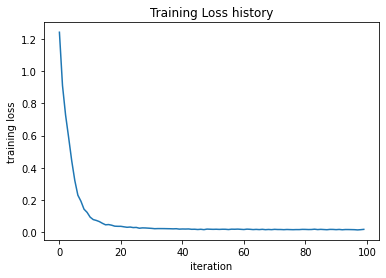

In [10]:
def init_toy_model_v4():
    np.random.seed(0)
    return TwoLayerNetv4(input_size, hidden_size, num_classes, std=1e-1)

net_v4 = init_toy_model_v4()
stats = net_v4.train(X, y, X, y,
            learning_rate=1e-1, reg=5e-6,
            num_iters=100, verbose=False)

print('Final training loss: ', stats['loss_history'][-1])

# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

b) We are now ready to train our model on a real image dataset. For this, we will use
the CIFAR-10 dataset.  Since the images are of size $32\times 32$ pixels with 3
color channels, this gives us 3072 input layer units, represented by a vector
$x\in\mathbb{R}^{3072}$. The code to load the data and train the model is provided with
some default hyperparameters. With default
hyperparameters, if previous questions have been done correctly, you should get
a validation set accuracy of about 29\%. This is very poor.
Your task is to debug the model training and come up with better hyperparameters
to improve the performance on the validation set.
Visualize the training and validation performance curves to help with this analysis.
There are several pointers provided in the comments to 
help you understand why the network might be underperforming.
Once you have tuned your hyperparameters, and get validation accuracy greater
than 48\% run your best model on the test set once and report the performance.

**Download CIFAR-10 using this link: <http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz>**
<br />
**Decompress the downloaded dataset, and put the `cifar-10-batches-py` folder in the foleder `datasets`**

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


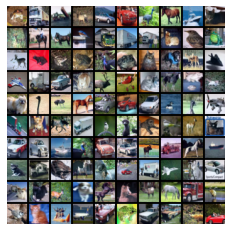

iteration 0 / 1000: loss 2.302985
iteration 100 / 1000: loss 2.302688
iteration 200 / 1000: loss 2.299744
iteration 300 / 1000: loss 2.274842
iteration 400 / 1000: loss 2.215889
iteration 500 / 1000: loss 2.148969
iteration 600 / 1000: loss 2.081402
iteration 700 / 1000: loss 1.999945
iteration 800 / 1000: loss 2.077575
iteration 900 / 1000: loss 2.044755
Validation accuracy:  0.282


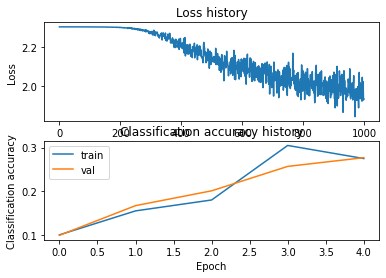

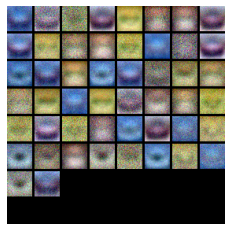

Learning rate:  1e-05
Hidden layer:  100
Reg strength:  5e-06
iteration 0 / 2000: loss 2.302611
iteration 100 / 2000: loss 2.302552
iteration 200 / 2000: loss 2.302518
iteration 300 / 2000: loss 2.302505
iteration 400 / 2000: loss 2.302385
iteration 500 / 2000: loss 2.302301
iteration 600 / 2000: loss 2.302245
iteration 700 / 2000: loss 2.302241
iteration 800 / 2000: loss 2.302187
iteration 900 / 2000: loss 2.301930
iteration 1000 / 2000: loss 2.301844
iteration 1100 / 2000: loss 2.301778
iteration 1200 / 2000: loss 2.301587
iteration 1300 / 2000: loss 2.301507
iteration 1400 / 2000: loss 2.300950
iteration 1500 / 2000: loss 2.300955
iteration 1600 / 2000: loss 2.300517
iteration 1700 / 2000: loss 2.299565
iteration 1800 / 2000: loss 2.300580
iteration 1900 / 2000: loss 2.299873
Validation accuracy:  0.211


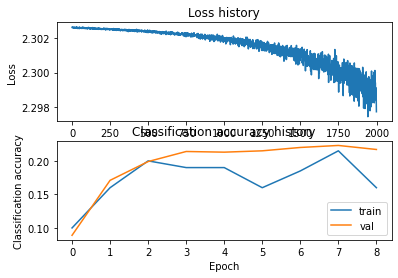

Learning rate:  1e-05
Hidden layer:  100
Reg strength:  0.0005
iteration 0 / 2000: loss 2.302582
iteration 100 / 2000: loss 2.302543
iteration 200 / 2000: loss 2.302497
iteration 300 / 2000: loss 2.302464
iteration 400 / 2000: loss 2.302396
iteration 500 / 2000: loss 2.302288
iteration 600 / 2000: loss 2.302300
iteration 700 / 2000: loss 2.302100
iteration 800 / 2000: loss 2.302180
iteration 900 / 2000: loss 2.302067
iteration 1000 / 2000: loss 2.301770
iteration 1100 / 2000: loss 2.301588
iteration 1200 / 2000: loss 2.301136
iteration 1300 / 2000: loss 2.301149
iteration 1400 / 2000: loss 2.300796
iteration 1500 / 2000: loss 2.300617
iteration 1600 / 2000: loss 2.300065
iteration 1700 / 2000: loss 2.299784
iteration 1800 / 2000: loss 2.298423
iteration 1900 / 2000: loss 2.299180
Validation accuracy:  0.177


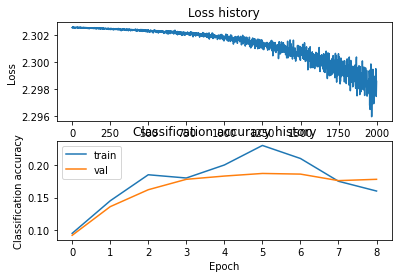

Learning rate:  1e-05
Hidden layer:  100
Reg strength:  0.05
iteration 0 / 2000: loss 2.302737
iteration 100 / 2000: loss 2.302674
iteration 200 / 2000: loss 2.302651
iteration 300 / 2000: loss 2.302628
iteration 400 / 2000: loss 2.302517
iteration 500 / 2000: loss 2.302459
iteration 600 / 2000: loss 2.302376
iteration 700 / 2000: loss 2.302349
iteration 800 / 2000: loss 2.302193
iteration 900 / 2000: loss 2.302156
iteration 1000 / 2000: loss 2.302015
iteration 1100 / 2000: loss 2.302024
iteration 1200 / 2000: loss 2.302061
iteration 1300 / 2000: loss 2.301707
iteration 1400 / 2000: loss 2.301282
iteration 1500 / 2000: loss 2.301331
iteration 1600 / 2000: loss 2.300502
iteration 1700 / 2000: loss 2.299435
iteration 1800 / 2000: loss 2.300231
iteration 1900 / 2000: loss 2.299375
Validation accuracy:  0.214


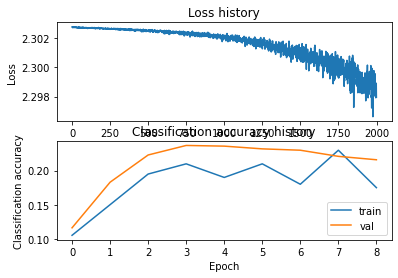

Learning rate:  0.0001
Hidden layer:  100
Reg strength:  5e-06
iteration 0 / 2000: loss 2.302604
iteration 100 / 2000: loss 2.302055
iteration 200 / 2000: loss 2.294175
iteration 300 / 2000: loss 2.231697
iteration 400 / 2000: loss 2.192103
iteration 500 / 2000: loss 2.137258
iteration 600 / 2000: loss 2.050650
iteration 700 / 2000: loss 1.990639
iteration 800 / 2000: loss 1.991448
iteration 900 / 2000: loss 1.979285
iteration 1000 / 2000: loss 2.000243
iteration 1100 / 2000: loss 1.931925
iteration 1200 / 2000: loss 1.837251
iteration 1300 / 2000: loss 1.780202
iteration 1400 / 2000: loss 1.878668
iteration 1500 / 2000: loss 1.831693
iteration 1600 / 2000: loss 1.931399
iteration 1700 / 2000: loss 1.825987
iteration 1800 / 2000: loss 1.796019
iteration 1900 / 2000: loss 1.716235
Validation accuracy:  0.372


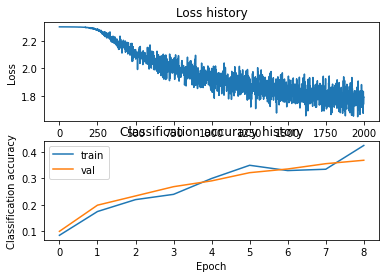

Learning rate:  0.0001
Hidden layer:  100
Reg strength:  0.0005
iteration 0 / 2000: loss 2.302572
iteration 100 / 2000: loss 2.301774
iteration 200 / 2000: loss 2.292876
iteration 300 / 2000: loss 2.229366
iteration 400 / 2000: loss 2.149522
iteration 500 / 2000: loss 2.099608
iteration 600 / 2000: loss 1.993802
iteration 700 / 2000: loss 1.972273
iteration 800 / 2000: loss 2.025665
iteration 900 / 2000: loss 1.925355
iteration 1000 / 2000: loss 1.875899
iteration 1100 / 2000: loss 1.827485
iteration 1200 / 2000: loss 1.869919
iteration 1300 / 2000: loss 1.854725
iteration 1400 / 2000: loss 1.774816
iteration 1500 / 2000: loss 1.774420
iteration 1600 / 2000: loss 1.772571
iteration 1700 / 2000: loss 1.778835
iteration 1800 / 2000: loss 1.758810
iteration 1900 / 2000: loss 1.759600
Validation accuracy:  0.377


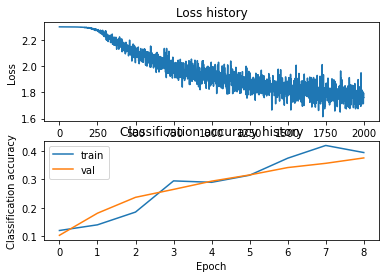

Learning rate:  0.0001
Hidden layer:  100
Reg strength:  0.05
iteration 0 / 2000: loss 2.302777
iteration 100 / 2000: loss 2.301710
iteration 200 / 2000: loss 2.288808
iteration 300 / 2000: loss 2.209803
iteration 400 / 2000: loss 2.164154
iteration 500 / 2000: loss 2.069303
iteration 600 / 2000: loss 2.085446
iteration 700 / 2000: loss 2.067679
iteration 800 / 2000: loss 1.986097
iteration 900 / 2000: loss 1.951990
iteration 1000 / 2000: loss 2.019606
iteration 1100 / 2000: loss 1.897111
iteration 1200 / 2000: loss 1.863028
iteration 1300 / 2000: loss 1.848600
iteration 1400 / 2000: loss 1.917666
iteration 1500 / 2000: loss 1.730124
iteration 1600 / 2000: loss 1.850330
iteration 1700 / 2000: loss 1.804929
iteration 1800 / 2000: loss 1.795346
iteration 1900 / 2000: loss 1.802297
Validation accuracy:  0.367


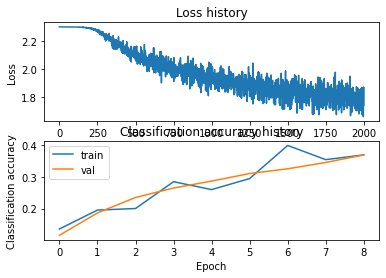

Learning rate:  0.001
Hidden layer:  100
Reg strength:  5e-06
iteration 0 / 2000: loss 2.302591
iteration 100 / 2000: loss 1.886289
iteration 200 / 2000: loss 1.713933
iteration 300 / 2000: loss 1.592858
iteration 400 / 2000: loss 1.619962
iteration 500 / 2000: loss 1.451342
iteration 600 / 2000: loss 1.488929
iteration 700 / 2000: loss 1.571558
iteration 800 / 2000: loss 1.491952
iteration 900 / 2000: loss 1.512249
iteration 1000 / 2000: loss 1.425932
iteration 1100 / 2000: loss 1.355209
iteration 1200 / 2000: loss 1.375242
iteration 1300 / 2000: loss 1.424329
iteration 1400 / 2000: loss 1.343884
iteration 1500 / 2000: loss 1.303917
iteration 1600 / 2000: loss 1.140796
iteration 1700 / 2000: loss 1.231769
iteration 1800 / 2000: loss 1.386503
iteration 1900 / 2000: loss 1.317139
Validation accuracy:  0.514


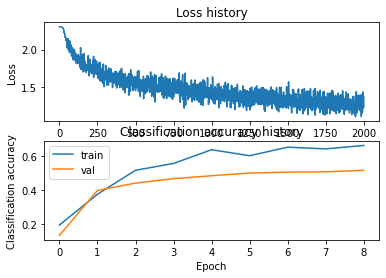

Learning rate:  0.001
Hidden layer:  100
Reg strength:  0.0005
iteration 0 / 2000: loss 2.302596
iteration 100 / 2000: loss 1.850663
iteration 200 / 2000: loss 1.777337
iteration 300 / 2000: loss 1.624259
iteration 400 / 2000: loss 1.563897
iteration 500 / 2000: loss 1.529244
iteration 600 / 2000: loss 1.738944
iteration 700 / 2000: loss 1.533489
iteration 800 / 2000: loss 1.412830
iteration 900 / 2000: loss 1.458968
iteration 1000 / 2000: loss 1.445701
iteration 1100 / 2000: loss 1.281332
iteration 1200 / 2000: loss 1.304562
iteration 1300 / 2000: loss 1.279526
iteration 1400 / 2000: loss 1.455168
iteration 1500 / 2000: loss 1.218697
iteration 1600 / 2000: loss 1.318267
iteration 1700 / 2000: loss 1.220704
iteration 1800 / 2000: loss 1.232960
iteration 1900 / 2000: loss 1.315258
Validation accuracy:  0.52


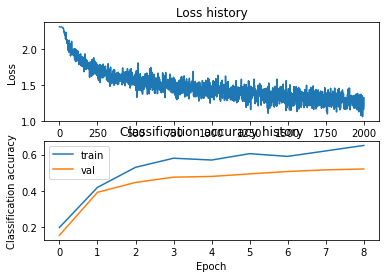

Learning rate:  0.001
Hidden layer:  100
Reg strength:  0.05
iteration 0 / 2000: loss 2.302760
iteration 100 / 2000: loss 1.973820
iteration 200 / 2000: loss 1.739133
iteration 300 / 2000: loss 1.709622
iteration 400 / 2000: loss 1.538539
iteration 500 / 2000: loss 1.598297
iteration 600 / 2000: loss 1.478181
iteration 700 / 2000: loss 1.544261
iteration 800 / 2000: loss 1.319938
iteration 900 / 2000: loss 1.346533
iteration 1000 / 2000: loss 1.372569
iteration 1100 / 2000: loss 1.364328
iteration 1200 / 2000: loss 1.423475
iteration 1300 / 2000: loss 1.417861
iteration 1400 / 2000: loss 1.249641
iteration 1500 / 2000: loss 1.268274
iteration 1600 / 2000: loss 1.160122
iteration 1700 / 2000: loss 1.401932
iteration 1800 / 2000: loss 1.423016
iteration 1900 / 2000: loss 1.453727
Validation accuracy:  0.516


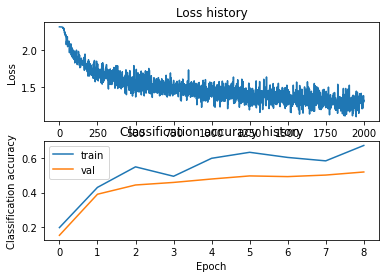

Learning rate:  1e-05
Hidden layer:  300
Reg strength:  5e-06
iteration 0 / 2000: loss 2.302609
iteration 100 / 2000: loss 2.302446
iteration 200 / 2000: loss 2.302290
iteration 300 / 2000: loss 2.302204
iteration 400 / 2000: loss 2.301935
iteration 500 / 2000: loss 2.301595
iteration 600 / 2000: loss 2.301629
iteration 700 / 2000: loss 2.301202
iteration 800 / 2000: loss 2.300973
iteration 900 / 2000: loss 2.301039
iteration 1000 / 2000: loss 2.299580
iteration 1100 / 2000: loss 2.299301
iteration 1200 / 2000: loss 2.298803
iteration 1300 / 2000: loss 2.298709
iteration 1400 / 2000: loss 2.297556
iteration 1500 / 2000: loss 2.296565
iteration 1600 / 2000: loss 2.294578
iteration 1700 / 2000: loss 2.293825
iteration 1800 / 2000: loss 2.290558
iteration 1900 / 2000: loss 2.293681
Validation accuracy:  0.201


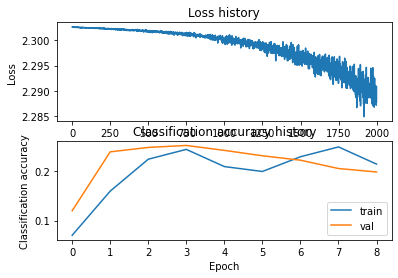

Learning rate:  1e-05
Hidden layer:  300
Reg strength:  0.0005
iteration 0 / 2000: loss 2.302633
iteration 100 / 2000: loss 2.302486
iteration 200 / 2000: loss 2.302335
iteration 300 / 2000: loss 2.302174
iteration 400 / 2000: loss 2.302153
iteration 500 / 2000: loss 2.302012
iteration 600 / 2000: loss 2.301534
iteration 700 / 2000: loss 2.301421
iteration 800 / 2000: loss 2.301299
iteration 900 / 2000: loss 2.300992
iteration 1000 / 2000: loss 2.300892
iteration 1100 / 2000: loss 2.299823
iteration 1200 / 2000: loss 2.299476
iteration 1300 / 2000: loss 2.299313
iteration 1400 / 2000: loss 2.298403
iteration 1500 / 2000: loss 2.297949
iteration 1600 / 2000: loss 2.295542
iteration 1700 / 2000: loss 2.295531
iteration 1800 / 2000: loss 2.294359
iteration 1900 / 2000: loss 2.291004
Validation accuracy:  0.222


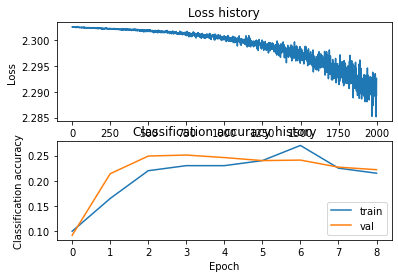

Learning rate:  1e-05
Hidden layer:  300
Reg strength:  0.05
iteration 0 / 2000: loss 2.303006
iteration 100 / 2000: loss 2.302904
iteration 200 / 2000: loss 2.302754
iteration 300 / 2000: loss 2.302561
iteration 400 / 2000: loss 2.302509
iteration 500 / 2000: loss 2.302159
iteration 600 / 2000: loss 2.301947
iteration 700 / 2000: loss 2.301947
iteration 800 / 2000: loss 2.301200
iteration 900 / 2000: loss 2.301048
iteration 1000 / 2000: loss 2.300139
iteration 1100 / 2000: loss 2.300144
iteration 1200 / 2000: loss 2.299995
iteration 1300 / 2000: loss 2.298458
iteration 1400 / 2000: loss 2.298175
iteration 1500 / 2000: loss 2.298408
iteration 1600 / 2000: loss 2.297909
iteration 1700 / 2000: loss 2.291314
iteration 1800 / 2000: loss 2.292420
iteration 1900 / 2000: loss 2.292249
Validation accuracy:  0.208


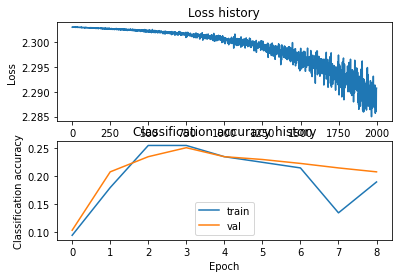

Learning rate:  0.0001
Hidden layer:  300
Reg strength:  5e-06
iteration 0 / 2000: loss 2.302553
iteration 100 / 2000: loss 2.300242
iteration 200 / 2000: loss 2.276341
iteration 300 / 2000: loss 2.224299
iteration 400 / 2000: loss 2.098242
iteration 500 / 2000: loss 2.054575
iteration 600 / 2000: loss 1.995518
iteration 700 / 2000: loss 1.937532
iteration 800 / 2000: loss 1.985743
iteration 900 / 2000: loss 1.889496
iteration 1000 / 2000: loss 1.917656
iteration 1100 / 2000: loss 1.830756
iteration 1200 / 2000: loss 1.818864
iteration 1300 / 2000: loss 1.718259
iteration 1400 / 2000: loss 1.747248
iteration 1500 / 2000: loss 1.893233
iteration 1600 / 2000: loss 1.837603
iteration 1700 / 2000: loss 1.684355
iteration 1800 / 2000: loss 1.799539
iteration 1900 / 2000: loss 1.792414
Validation accuracy:  0.374


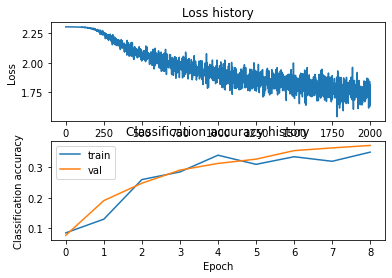

Learning rate:  0.0001
Hidden layer:  300
Reg strength:  0.0005
iteration 0 / 2000: loss 2.302600
iteration 100 / 2000: loss 2.299471
iteration 200 / 2000: loss 2.272135
iteration 300 / 2000: loss 2.188181
iteration 400 / 2000: loss 2.131859
iteration 500 / 2000: loss 2.028364
iteration 600 / 2000: loss 1.916779
iteration 700 / 2000: loss 1.996776
iteration 800 / 2000: loss 1.891917
iteration 900 / 2000: loss 1.919314
iteration 1000 / 2000: loss 1.804287
iteration 1100 / 2000: loss 1.904113
iteration 1200 / 2000: loss 1.943479
iteration 1300 / 2000: loss 1.839490
iteration 1400 / 2000: loss 1.835756
iteration 1500 / 2000: loss 1.795811
iteration 1600 / 2000: loss 1.751344
iteration 1700 / 2000: loss 1.732123
iteration 1800 / 2000: loss 1.762858
iteration 1900 / 2000: loss 1.867212
Validation accuracy:  0.376


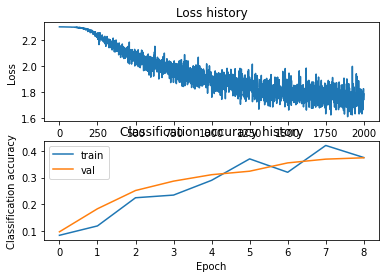

Learning rate:  0.0001
Hidden layer:  300
Reg strength:  0.05
iteration 0 / 2000: loss 2.303064
iteration 100 / 2000: loss 2.300672
iteration 200 / 2000: loss 2.283899
iteration 300 / 2000: loss 2.175834
iteration 400 / 2000: loss 2.131782
iteration 500 / 2000: loss 2.113961
iteration 600 / 2000: loss 2.006095
iteration 700 / 2000: loss 1.967926
iteration 800 / 2000: loss 1.927409
iteration 900 / 2000: loss 1.836707
iteration 1000 / 2000: loss 1.845408
iteration 1100 / 2000: loss 1.896711
iteration 1200 / 2000: loss 1.886717
iteration 1300 / 2000: loss 1.834708
iteration 1400 / 2000: loss 1.868692
iteration 1500 / 2000: loss 1.790078
iteration 1600 / 2000: loss 1.881679
iteration 1700 / 2000: loss 1.707929
iteration 1800 / 2000: loss 1.840424
iteration 1900 / 2000: loss 1.728073
Validation accuracy:  0.377


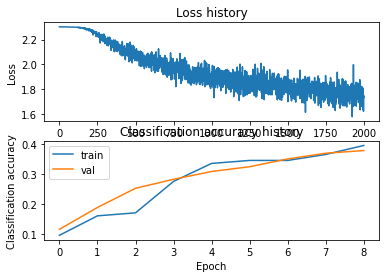

Learning rate:  0.001
Hidden layer:  300
Reg strength:  5e-06
iteration 0 / 2000: loss 2.302562
iteration 100 / 2000: loss 1.886522
iteration 200 / 2000: loss 1.755162
iteration 300 / 2000: loss 1.535918
iteration 400 / 2000: loss 1.534884
iteration 500 / 2000: loss 1.542589
iteration 600 / 2000: loss 1.564808
iteration 700 / 2000: loss 1.542503
iteration 800 / 2000: loss 1.360710
iteration 900 / 2000: loss 1.408407
iteration 1000 / 2000: loss 1.425821
iteration 1100 / 2000: loss 1.455917
iteration 1200 / 2000: loss 1.387352
iteration 1300 / 2000: loss 1.286770
iteration 1400 / 2000: loss 1.360852
iteration 1500 / 2000: loss 1.333681
iteration 1600 / 2000: loss 1.290911
iteration 1700 / 2000: loss 1.337831
iteration 1800 / 2000: loss 1.152088
iteration 1900 / 2000: loss 1.201877
Validation accuracy:  0.516


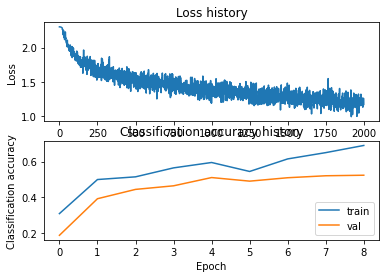

Learning rate:  0.001
Hidden layer:  300
Reg strength:  0.0005
iteration 0 / 2000: loss 2.302620
iteration 100 / 2000: loss 1.907972
iteration 200 / 2000: loss 1.777794
iteration 300 / 2000: loss 1.702072
iteration 400 / 2000: loss 1.586040
iteration 500 / 2000: loss 1.377604
iteration 600 / 2000: loss 1.428559
iteration 700 / 2000: loss 1.378288
iteration 800 / 2000: loss 1.548130
iteration 900 / 2000: loss 1.388628
iteration 1000 / 2000: loss 1.437913
iteration 1100 / 2000: loss 1.373453
iteration 1200 / 2000: loss 1.425974
iteration 1300 / 2000: loss 1.403922
iteration 1400 / 2000: loss 1.311459
iteration 1500 / 2000: loss 1.181606
iteration 1600 / 2000: loss 1.363654
iteration 1700 / 2000: loss 1.304101
iteration 1800 / 2000: loss 1.080942
iteration 1900 / 2000: loss 1.219428
Validation accuracy:  0.526


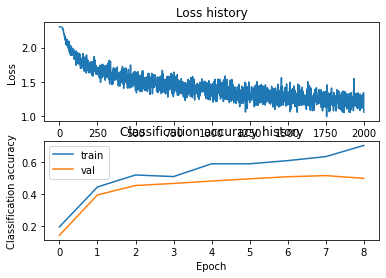

Learning rate:  0.001
Hidden layer:  300
Reg strength:  0.05
iteration 0 / 2000: loss 2.303056
iteration 100 / 2000: loss 1.898991
iteration 200 / 2000: loss 1.768710
iteration 300 / 2000: loss 1.605890
iteration 400 / 2000: loss 1.634390
iteration 500 / 2000: loss 1.565149
iteration 600 / 2000: loss 1.655525
iteration 700 / 2000: loss 1.532393
iteration 800 / 2000: loss 1.481942
iteration 900 / 2000: loss 1.345088
iteration 1000 / 2000: loss 1.444924
iteration 1100 / 2000: loss 1.273020
iteration 1200 / 2000: loss 1.361182
iteration 1300 / 2000: loss 1.308437
iteration 1400 / 2000: loss 1.307973
iteration 1500 / 2000: loss 1.406352
iteration 1600 / 2000: loss 1.373178
iteration 1700 / 2000: loss 1.266411
iteration 1800 / 2000: loss 1.176309
iteration 1900 / 2000: loss 1.279491
Validation accuracy:  0.532


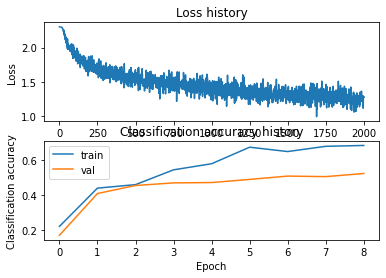

Learning rate:  1e-05
Hidden layer:  500
Reg strength:  5e-06
iteration 0 / 2000: loss 2.302500
iteration 100 / 2000: loss 2.302307
iteration 200 / 2000: loss 2.301981
iteration 300 / 2000: loss 2.301930
iteration 400 / 2000: loss 2.301662
iteration 500 / 2000: loss 2.301176
iteration 600 / 2000: loss 2.300694
iteration 700 / 2000: loss 2.300667
iteration 800 / 2000: loss 2.300421
iteration 900 / 2000: loss 2.299071
iteration 1000 / 2000: loss 2.298850
iteration 1100 / 2000: loss 2.298626
iteration 1200 / 2000: loss 2.297210
iteration 1300 / 2000: loss 2.296509
iteration 1400 / 2000: loss 2.294240
iteration 1500 / 2000: loss 2.291928
iteration 1600 / 2000: loss 2.292051
iteration 1700 / 2000: loss 2.292547
iteration 1800 / 2000: loss 2.286860
iteration 1900 / 2000: loss 2.283281
Validation accuracy:  0.221


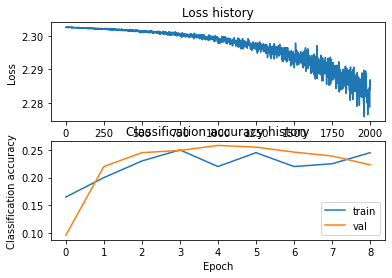

Learning rate:  1e-05
Hidden layer:  500
Reg strength:  0.0005
iteration 0 / 2000: loss 2.302591
iteration 100 / 2000: loss 2.302440
iteration 200 / 2000: loss 2.302218
iteration 300 / 2000: loss 2.301852
iteration 400 / 2000: loss 2.301636
iteration 500 / 2000: loss 2.301331
iteration 600 / 2000: loss 2.301134
iteration 700 / 2000: loss 2.300533
iteration 800 / 2000: loss 2.300793
iteration 900 / 2000: loss 2.299742
iteration 1000 / 2000: loss 2.299032
iteration 1100 / 2000: loss 2.297795
iteration 1200 / 2000: loss 2.298026
iteration 1300 / 2000: loss 2.297447
iteration 1400 / 2000: loss 2.296208
iteration 1500 / 2000: loss 2.293117
iteration 1600 / 2000: loss 2.290576
iteration 1700 / 2000: loss 2.292568
iteration 1800 / 2000: loss 2.292520
iteration 1900 / 2000: loss 2.281192
Validation accuracy:  0.225


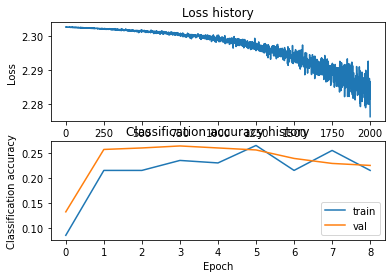

Learning rate:  1e-05
Hidden layer:  500
Reg strength:  0.05
iteration 0 / 2000: loss 2.303397
iteration 100 / 2000: loss 2.303044
iteration 200 / 2000: loss 2.302873
iteration 300 / 2000: loss 2.302787
iteration 400 / 2000: loss 2.302321
iteration 500 / 2000: loss 2.302163
iteration 600 / 2000: loss 2.301916
iteration 700 / 2000: loss 2.300962
iteration 800 / 2000: loss 2.300334
iteration 900 / 2000: loss 2.299861
iteration 1000 / 2000: loss 2.299460
iteration 1100 / 2000: loss 2.299077
iteration 1200 / 2000: loss 2.298569
iteration 1300 / 2000: loss 2.295442
iteration 1400 / 2000: loss 2.297008
iteration 1500 / 2000: loss 2.294077
iteration 1600 / 2000: loss 2.294419
iteration 1700 / 2000: loss 2.290820
iteration 1800 / 2000: loss 2.289738
iteration 1900 / 2000: loss 2.285872
Validation accuracy:  0.216


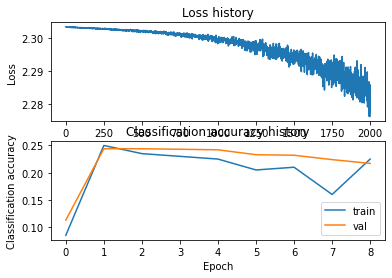

Learning rate:  0.0001
Hidden layer:  500
Reg strength:  5e-06
iteration 0 / 2000: loss 2.302556
iteration 100 / 2000: loss 2.297853
iteration 200 / 2000: loss 2.263610
iteration 300 / 2000: loss 2.189437
iteration 400 / 2000: loss 2.113560
iteration 500 / 2000: loss 2.055542
iteration 600 / 2000: loss 1.953605
iteration 700 / 2000: loss 1.959484
iteration 800 / 2000: loss 1.911943
iteration 900 / 2000: loss 1.926531
iteration 1000 / 2000: loss 1.922536
iteration 1100 / 2000: loss 1.870904
iteration 1200 / 2000: loss 1.883883
iteration 1300 / 2000: loss 1.792883
iteration 1400 / 2000: loss 1.888509
iteration 1500 / 2000: loss 1.794827
iteration 1600 / 2000: loss 1.807355
iteration 1700 / 2000: loss 1.703897
iteration 1800 / 2000: loss 1.653943
iteration 1900 / 2000: loss 1.817025
Validation accuracy:  0.384


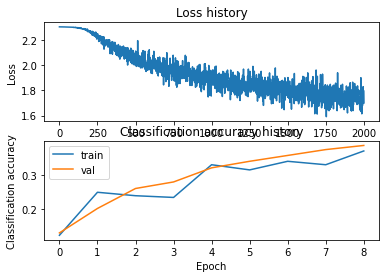

Learning rate:  0.0001
Hidden layer:  500
Reg strength:  0.0005
iteration 0 / 2000: loss 2.302598
iteration 100 / 2000: loss 2.298566
iteration 200 / 2000: loss 2.269466
iteration 300 / 2000: loss 2.151205
iteration 400 / 2000: loss 2.110564
iteration 500 / 2000: loss 2.101152
iteration 600 / 2000: loss 1.978592
iteration 700 / 2000: loss 1.911664
iteration 800 / 2000: loss 1.946114
iteration 900 / 2000: loss 1.975896
iteration 1000 / 2000: loss 1.886496
iteration 1100 / 2000: loss 1.731833
iteration 1200 / 2000: loss 1.877357
iteration 1300 / 2000: loss 1.791941
iteration 1400 / 2000: loss 1.840975
iteration 1500 / 2000: loss 1.818853
iteration 1600 / 2000: loss 1.792681
iteration 1700 / 2000: loss 1.771988
iteration 1800 / 2000: loss 1.736985
iteration 1900 / 2000: loss 1.763316
Validation accuracy:  0.377


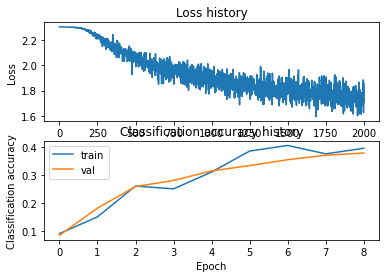

Learning rate:  0.0001
Hidden layer:  500
Reg strength:  0.05
iteration 0 / 2000: loss 2.303350
iteration 100 / 2000: loss 2.298063
iteration 200 / 2000: loss 2.275499
iteration 300 / 2000: loss 2.170556
iteration 400 / 2000: loss 2.113161
iteration 500 / 2000: loss 2.087917
iteration 600 / 2000: loss 1.930857
iteration 700 / 2000: loss 1.905476
iteration 800 / 2000: loss 1.978458
iteration 900 / 2000: loss 1.959035
iteration 1000 / 2000: loss 1.826656
iteration 1100 / 2000: loss 1.913511
iteration 1200 / 2000: loss 1.790838
iteration 1300 / 2000: loss 1.822356
iteration 1400 / 2000: loss 1.719123
iteration 1500 / 2000: loss 1.773660
iteration 1600 / 2000: loss 1.808112
iteration 1700 / 2000: loss 1.807145
iteration 1800 / 2000: loss 1.762614
iteration 1900 / 2000: loss 1.712775
Validation accuracy:  0.378


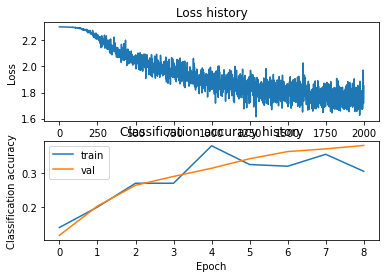

Learning rate:  0.001
Hidden layer:  500
Reg strength:  5e-06
iteration 0 / 2000: loss 2.302607
iteration 100 / 2000: loss 1.879174
iteration 200 / 2000: loss 1.767469
iteration 300 / 2000: loss 1.569185
iteration 400 / 2000: loss 1.769381
iteration 500 / 2000: loss 1.403741
iteration 600 / 2000: loss 1.535358
iteration 700 / 2000: loss 1.450987
iteration 800 / 2000: loss 1.395247
iteration 900 / 2000: loss 1.339727
iteration 1000 / 2000: loss 1.489494
iteration 1100 / 2000: loss 1.512444
iteration 1200 / 2000: loss 1.382706
iteration 1300 / 2000: loss 1.264013
iteration 1400 / 2000: loss 1.159527
iteration 1500 / 2000: loss 1.392837
iteration 1600 / 2000: loss 1.218983
iteration 1700 / 2000: loss 1.115307
iteration 1800 / 2000: loss 1.253623
iteration 1900 / 2000: loss 1.164449
Validation accuracy:  0.526


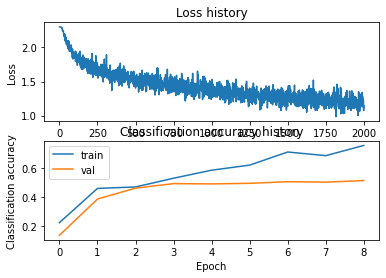

Learning rate:  0.001
Hidden layer:  500
Reg strength:  0.0005
iteration 0 / 2000: loss 2.302667
iteration 100 / 2000: loss 1.826418
iteration 200 / 2000: loss 1.743174
iteration 300 / 2000: loss 1.676467
iteration 400 / 2000: loss 1.588700
iteration 500 / 2000: loss 1.708852
iteration 600 / 2000: loss 1.527485
iteration 700 / 2000: loss 1.407408
iteration 800 / 2000: loss 1.400976
iteration 900 / 2000: loss 1.474623
iteration 1000 / 2000: loss 1.315144
iteration 1100 / 2000: loss 1.356223
iteration 1200 / 2000: loss 1.291230
iteration 1300 / 2000: loss 1.377487
iteration 1400 / 2000: loss 1.345136
iteration 1500 / 2000: loss 1.267627
iteration 1600 / 2000: loss 1.242022
iteration 1700 / 2000: loss 1.229262
iteration 1800 / 2000: loss 1.138462
iteration 1900 / 2000: loss 1.105177
Validation accuracy:  0.525


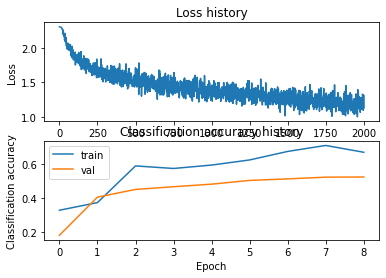

Learning rate:  0.001
Hidden layer:  500
Reg strength:  0.05
iteration 0 / 2000: loss 2.303354
iteration 100 / 2000: loss 1.961905
iteration 200 / 2000: loss 1.683368
iteration 300 / 2000: loss 1.621452
iteration 400 / 2000: loss 1.550292
iteration 500 / 2000: loss 1.571175
iteration 600 / 2000: loss 1.571160
iteration 700 / 2000: loss 1.561293
iteration 800 / 2000: loss 1.469986
iteration 900 / 2000: loss 1.401633
iteration 1000 / 2000: loss 1.351719
iteration 1100 / 2000: loss 1.247196
iteration 1200 / 2000: loss 1.322489
iteration 1300 / 2000: loss 1.352350
iteration 1400 / 2000: loss 1.262381
iteration 1500 / 2000: loss 1.231594
iteration 1600 / 2000: loss 1.291633
iteration 1700 / 2000: loss 1.280669
iteration 1800 / 2000: loss 1.271389
iteration 1900 / 2000: loss 1.246587
Validation accuracy:  0.505


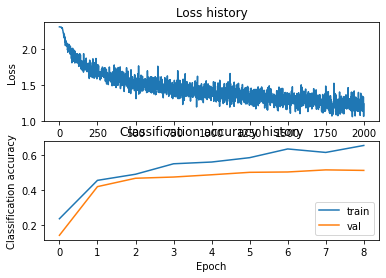

Best learning rate:  0.001
Best size for hidden layer:  300
Best reg:  0.05
iteration 0 / 20000: loss 1.226196
iteration 100 / 20000: loss 1.354842
iteration 200 / 20000: loss 1.237142
iteration 300 / 20000: loss 1.307395
iteration 400 / 20000: loss 1.358516
iteration 500 / 20000: loss 1.293372
iteration 600 / 20000: loss 1.262905
iteration 700 / 20000: loss 1.270777
iteration 800 / 20000: loss 1.139732
iteration 900 / 20000: loss 1.256058
iteration 1000 / 20000: loss 1.296919
iteration 1100 / 20000: loss 1.316070
iteration 1200 / 20000: loss 1.222470
iteration 1300 / 20000: loss 1.314323
iteration 1400 / 20000: loss 1.156980
iteration 1500 / 20000: loss 1.260614
iteration 1600 / 20000: loss 1.280485
iteration 1700 / 20000: loss 1.198314
iteration 1800 / 20000: loss 1.245019
iteration 1900 / 20000: loss 1.113574
iteration 2000 / 20000: loss 1.165101
iteration 2100 / 20000: loss 1.186349
iteration 2200 / 20000: loss 1.218836
iteration 2300 / 20000: loss 1.182281
iteration 2400 / 20000: 

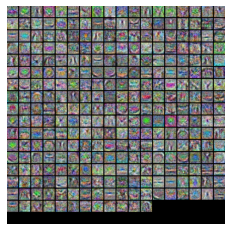

Test accuracy:  0.565


In [45]:
random.seed(10) 

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

# # Load the data
# Now that you have implemented a two-layer network that passes
# gradient checks and works on toy data, it's time to load up our favorite
# CIFAR-10 data so we can use it to train a classifier on a real dataset.
# Invoke the get_CIFAR10_data function to get our data.

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

# Visualize some images to get a feel for the data
plt.imshow(visualize_grid(X_train[:100, :].reshape(100, 32,32, 3), padding=3).astype('uint8'))
plt.gca().axis('off')
plt.show()

# # Train a network
# To train our network we will use SGD. In addition, we will
# adjust the learning rate with an exponential learning rate schedule as
# optimization proceeds; after each epoch, we will reduce the learning rate by
# multiplying it by a decay rate.

input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNetv4(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.25, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

# # Debug the training
# With the default parameters we provided above, you should get a validation
# accuracy of about 0.29 on the validation set. This isn't very good.
#
# One strategy for getting insight into what's wrong is to plot the loss
# function and the accuracies on the training and validation sets during
# optimization.
#
# Another strategy is to visualize the weights that were learned in the first
# layer of the network. In most neural networks trained on visual data, the
# first layer weights typically show some visible structure when visualized.

# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()


# Visualize the weights of the network

show_net_weights(net)

# # Tune your hyperparameters
#
# **What's wrong?**. Looking at the visualizations above, we see that the loss
# is decreasing more or less linearly, which seems to suggest that the learning
# rate may be too low. Moreover, there is no gap between the training and
# validation accuracy, suggesting that the model we used has low capacity, and
# that we should increase its size. On the other hand, with a very large model
# we would expect to see more overfitting, which would manifest itself as a
# very large gap between the training and validation accuracy.
#
# **Tuning**. Tuning the hyperparameters and developing intuition for how they
# affect the final performance is a large part of using Neural Networks, so we
# want you to get a lot of practice. Below, you should experiment with
# different values of the various hyperparameters, including hidden layer size,
# learning rate, numer of training epochs, and regularization strength. You
# might also consider tuning the learning rate decay, but you should be able to
# get good performance using the default value.
#
# **Approximate results**. You should be aim to achieve a classification
# accuracy of greater than 48% on the validation set. Our best network gets
# over 52% on the validation set.
#
# **Experiment**: You goal in this exercise is to get as good of a result on
# CIFAR-10 as you can (52% could serve as a reference), with a fully-connected
# Neural Network. Feel free implement your own techniques (e.g. PCA to reduce
# dimensionality, or adding dropout, or adding features to the solver, etc.).

# **Explain your hyperparameter tuning process in the report.**

best_net = None # store the best model into this

#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_net.                                                            #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters by hand can be fun, but you might find it useful to  #
# write code to sweep through possible combinations of hyperparameters          #

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

learning_rates = [1e-5, 1e-4, 1e-3]
hidden_sizes = [100, 300, 500]
reg_strength = [5e-6, 5e-4, 5e-2]
best_reg = best_hidden_size = best_lr = best_acc = 0

for hidden_size in hidden_sizes:      
    for learning_rate in learning_rates:
        for rs in reg_strength:

            print("Learning rate: ", learning_rate)
            print("Hidden layer: ", hidden_size)
            print("Reg strength: ", rs)

            
            net = TwoLayerNetv4(input_size, hidden_size, num_classes)
            
            stats = net.train(X_train, y_train, X_val, y_val,
                        num_iters = 2000, batch_size = 200,
                        learning_rate = learning_rate, learning_rate_decay = 0.95,
                        reg = rs, verbose=True)

            val_acc = (net.predict(X_val) == y_val).mean()
            print('Validation accuracy: ', val_acc)

            if val_acc > best_acc:
                best_acc = val_acc
                best_net = net
                best_lr = learning_rate
                best_hidden_size = hidden_size
                best_reg = rs

            plt.subplot(2, 1, 1)
            plt.plot(stats['loss_history'])
            plt.title('Loss history')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')

            plt.subplot(2, 1, 2)
            plt.plot(stats['train_acc_history'], label='train')
            plt.plot(stats['val_acc_history'], label='val')
            plt.title('Classification accuracy history')
            plt.xlabel('Epoch')
            plt.ylabel('Classification accuracy')
            plt.legend()
            plt.show()

print("Best learning rate: ", best_lr)
print("Best size for hidden layer: ", best_hidden_size)
print("Best reg: ", best_reg)


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# visualize the weights of the best network
stats = best_net.train(X_train, y_train, X_val, y_val,
            num_iters=20000, batch_size=200,
            learning_rate=0.7 * 1e-3, learning_rate_decay=0.90,
            reg=0.20, verbose=True)

# Predict on the validation set
val_acc = (best_net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)
show_net_weights(best_net)


# # Run on the test set
# When you are done experimenting, you should evaluate your final trained
# network on the test set; you should get above 48%.

test_acc = (best_net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

### Question 4: Implement multi-layer perceptron using PyTorch library (10 points)

So far, we have implemented a two-layer network by explicitly writing down the expressions for the forward and backward computations and training algorithms using simple matrix multiplication primitives from the NumPy library.

However there are many libraries available designed make experimenting with neural networks faster by abstracting away the details into re-usable modules. One such popular open-source library is PyTorch (https://pytorch.org/). In this final question we will use the PyTorch library to implement the same two-layer network we did before and train it on the Cifar-10 dataset. However, extending a two-layer network to a three or four layered one is a matter of changing two-three lines of code using PyTorch. We will take advantage of this to experiment with deeper networks to improve the performance on the CIFAR-10 classification.

To install the pytorch library follow the instruction in
https://pytorch.org/get-started/locally/ . If you have access to a Graphics Processing
Unit (GPU), you can install the gpu verison and run the exercise on GPU for faster run
times. If not, you can install the cpu version (select cuda version None) and run on the
cpu. Having gpu access is not necessary to complete the exercise.  There are good tutorials
for getting started with pytorch on their website (https://pytorch.org/tutorials/).

a) Complete the code to implement a multi-layer perceptron network in the class
`MultiLayerPerceptron`. This includes instantiating the
required layers from `torch.nn` and writing the code for forward pass. Initially you 
should write the code for the same two-layer network we have seen before.
(3 points)

In [16]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import sys

def weights_init(m):
    if type(m) == nn.Linear:
        m.weight.data.normal_(0.0, 1e-3)
        m.bias.data.fill_(0.)

def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

#--------------------------------
# Device configuration
#--------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: %s'%device)

#--------------------------------
# Hyper-parameters
#--------------------------------

input_size = 32 * 32 * 3
hidden_size = [50]
num_classes = 10
num_epochs = 20
batch_size = 200
learning_rate = 1e-3
learning_rate_decay = 0.95
reg=0.001
num_training= 49000
num_validation =1000
train = True

#-------------------------------------------------
# Load the CIFAR-10 dataset
#-------------------------------------------------
norm_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                     ])
cifar_dataset = torchvision.datasets.CIFAR10(root='datasets/',
                                           train=True,
                                           transform=norm_transform,
                                           download=False)

test_dataset = torchvision.datasets.CIFAR10(root='datasets/',
                                          train=False,
                                          transform=norm_transform
                                          )
#-------------------------------------------------
# Prepare the training and validation splits
#-------------------------------------------------
mask = list(range(num_training))
train_dataset = torch.utils.data.Subset(cifar_dataset, mask)
mask = list(range(num_training, num_training + num_validation))
val_dataset = torch.utils.data.Subset(cifar_dataset, mask)

#-------------------------------------------------
# Data loader
#-------------------------------------------------
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

Using device: cuda


In [55]:
#======================================================================================
# Q4: Implementing multi-layer perceptron in PyTorch
#======================================================================================
# So far we have implemented a two-layer network using numpy by explicitly
# writing down the forward computation and deriving and implementing the
# equations for backward computation. This process can be tedious to extend to
# large network architectures
#
# Popular deep-learining libraries like PyTorch and Tensorflow allow us to
# quickly implement complicated neural network architectures. They provide
# pre-defined layers which can be used as building blocks to define our
# network. They also enable automatic-differentiation, which allows us to
# define only the forward pass and let the libraries perform back-propagation
# using automatic differentiation.
#
# In this question we will implement a multi-layer perceptron using the PyTorch
# library.  Please complete the code for the MultiLayerPerceptron, training and
# evaluating the model. Once you can train the two layer model, experiment with
# adding more layers and
#--------------------------------------------------------------------------------------

#-------------------------------------------------
# Fully connected neural network with one hidden layer
#-------------------------------------------------
class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_size, hidden_layers, num_classes):
        super(MultiLayerPerceptron, self).__init__()
        #################################################################################
        # TODO: Initialize the modules required to implement the mlp with given layer   #
        # configuration. input_size --> hidden_layers[0] --> hidden_layers[1] .... -->  #
        # hidden_layers[-1] --> num_classes                                             #
        # Make use of linear and relu layers from the torch.nn module                   #
        #################################################################################
        layers = []
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
        layers.append(nn.Linear(input_size, hidden_layers[0]))
        layers.append(nn.ReLU())
        
        for i in range(len(hidden_layers) - 1):
                layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
                layers.append(nn.ReLU())
        
        layers.append(nn.Linear(hidden_layers[-1], num_classes))
            
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        #################################################################################
        # TODO: Implement the forward pass computations                                 #
        # Note that you do not need to use the softmax operation at the end.            #
        # Softmax is only required for the loss computation and the criterion used below#
        # nn.CrossEntropyLoss() already integrates the softmax and the log loss together#
        #################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
        return self.layers(x)
    
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


model = MultiLayerPerceptron(input_size, hidden_size, num_classes).to(device)

b) Complete the code to train the network. Make use of the loss function `torch.nn.CrossEntropyLoss` to compute the loss and `loss.backward()` to compute the gradients. Once gradients are computed, `optimizer.step()` can be invoked to update the model. Your should be able to achieve similar performance ($>$ 48\% accuracy on the validation set) as in Q3. Report the final validation accuracy you achieve with a two-layer network. (3 points)

In [56]:
# Training
model.apply(weights_init)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg)

# Train the model
lr = learning_rate
total_step = len(train_loader)
for epoch in range(num_epochs):
    correct = 0
    total = 0 
    for i, (images, labels) in enumerate(train_loader):
        # if(i>2):
        #     break
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        #################################################################################
        # TODO: Implement the training code                                             #
        # 1. Pass the images to the model                                               #
        # 2. Compute the loss using the output and the labels.                          #
        # 3. Compute gradients and update the model using the optimizer                 #
        # Use examples in https://pytorch.org/tutorials/beginner/pytorch_with_examples.html
        #################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
        model.train() # set it to train mode
        optimizer.zero_grad()
        
        images = images.reshape(-1, input_size)
     
        scores = model(images)
        predicted = torch.max(scores, axis = 1)[1]
        loss = criterion(scores, labels)

        loss.backward()
        optimizer.step()
        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        if (i+1) % 10 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Train accuracy is: {} %'.format(100 * correct / total))
    # Code to update the lr
    lr *= learning_rate_decay
    update_lr(optimizer, lr)
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            ####################################################
            # TODO: Implement the evaluation code              #
            # 1. Pass the images to the model                  #
            # 2. Get the most confident predicted class        #
            ####################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
            
            model.eval() # set it to eval mode
            
            images = images.reshape(-1, input_size)
            scores = model(images)
            predicted = torch.max(scores, axis = 1)[1]
            
            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Validataion accuracy is: {} %'.format(100 * correct / total))

##################################################################################
# TODO: Now that you can train a simple two-layer MLP using above code, you can  #
# easily experiment with adding more layers and different layer configurations   #
# and let the pytorch library handle computing the gradients                     #
#                                                                                #
# Experiment with different number of layers (atleast from 2 to 5 layers) and    #
# record the final validation accuracies Report your observations on how adding  #
# more layers to the MLP affects its behavior. Try to improve the model          #
# configuration using the validation performance as the guidance. You can        #
# experiment with different activation layers available in torch.nn, adding      #
# dropout layers, if you are interested. Use the best model on the validation    #
# set, to evaluate the performance on the test set once and report it            #
##################################################################################

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

# Run the test code once you have your by setting train flag to false
# and loading the best model

best_model = None # torch.load()
best_model = torch.load('model.ckpt')
model.load_state_dict(best_model)
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        ####################################################
        # TODO: Implement the evaluation code              #
        # 1. Pass the images to the model                  #
        # 2. Get the most confident predicted class        #
        ####################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        model.eval() # set it to eval mode

        images = images.reshape(-1, input_size)
        scores = model(images)
        predicted = torch.max(scores, axis = 1)[1]
        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if total == 1000:
            break

    print('Accuracy of the network on the {} test images: {} %'.format(total, 100 * correct / total))

Epoch [1/20], Step [10/245], Loss: 2.1216
Epoch [1/20], Step [20/245], Loss: 2.1090
Epoch [1/20], Step [30/245], Loss: 2.0216
Epoch [1/20], Step [40/245], Loss: 1.8919
Epoch [1/20], Step [50/245], Loss: 1.8761
Epoch [1/20], Step [60/245], Loss: 1.8300
Epoch [1/20], Step [70/245], Loss: 1.8600
Epoch [1/20], Step [80/245], Loss: 1.7654
Epoch [1/20], Step [90/245], Loss: 1.7246
Epoch [1/20], Step [100/245], Loss: 1.7108
Epoch [1/20], Step [110/245], Loss: 1.7003
Epoch [1/20], Step [120/245], Loss: 1.7950
Epoch [1/20], Step [130/245], Loss: 1.7298
Epoch [1/20], Step [140/245], Loss: 1.6897
Epoch [1/20], Step [150/245], Loss: 1.8634
Epoch [1/20], Step [160/245], Loss: 1.6784
Epoch [1/20], Step [170/245], Loss: 1.5406
Epoch [1/20], Step [180/245], Loss: 1.7102
Epoch [1/20], Step [190/245], Loss: 1.6189
Epoch [1/20], Step [200/245], Loss: 1.6200
Epoch [1/20], Step [210/245], Loss: 1.7282
Epoch [1/20], Step [220/245], Loss: 1.5804
Epoch [1/20], Step [230/245], Loss: 1.5165
Epoch [1/20], Step [

Epoch [8/20], Step [140/245], Loss: 1.3584
Epoch [8/20], Step [150/245], Loss: 1.3610
Epoch [8/20], Step [160/245], Loss: 1.3412
Epoch [8/20], Step [170/245], Loss: 1.4609
Epoch [8/20], Step [180/245], Loss: 1.2657
Epoch [8/20], Step [190/245], Loss: 1.2062
Epoch [8/20], Step [200/245], Loss: 1.4526
Epoch [8/20], Step [210/245], Loss: 1.3544
Epoch [8/20], Step [220/245], Loss: 1.3216
Epoch [8/20], Step [230/245], Loss: 1.4001
Epoch [8/20], Step [240/245], Loss: 1.3294
Train accuracy is: 53.073469387755104 %
Validataion accuracy is: 49.8 %
Epoch [9/20], Step [10/245], Loss: 1.3850
Epoch [9/20], Step [20/245], Loss: 1.2386
Epoch [9/20], Step [30/245], Loss: 1.3056
Epoch [9/20], Step [40/245], Loss: 1.1920
Epoch [9/20], Step [50/245], Loss: 1.1900
Epoch [9/20], Step [60/245], Loss: 1.3447
Epoch [9/20], Step [70/245], Loss: 1.4456
Epoch [9/20], Step [80/245], Loss: 1.2616
Epoch [9/20], Step [90/245], Loss: 1.3423
Epoch [9/20], Step [100/245], Loss: 1.4883
Epoch [9/20], Step [110/245], Loss

Epoch [15/20], Step [240/245], Loss: 1.2374
Train accuracy is: 56.875510204081635 %
Validataion accuracy is: 53.2 %
Epoch [16/20], Step [10/245], Loss: 1.2171
Epoch [16/20], Step [20/245], Loss: 1.2963
Epoch [16/20], Step [30/245], Loss: 1.3265
Epoch [16/20], Step [40/245], Loss: 1.2131
Epoch [16/20], Step [50/245], Loss: 1.1563
Epoch [16/20], Step [60/245], Loss: 1.1897
Epoch [16/20], Step [70/245], Loss: 1.2496
Epoch [16/20], Step [80/245], Loss: 1.1220
Epoch [16/20], Step [90/245], Loss: 1.1619
Epoch [16/20], Step [100/245], Loss: 1.1721
Epoch [16/20], Step [110/245], Loss: 1.2968
Epoch [16/20], Step [120/245], Loss: 1.1544
Epoch [16/20], Step [130/245], Loss: 1.1958
Epoch [16/20], Step [140/245], Loss: 1.2114
Epoch [16/20], Step [150/245], Loss: 1.2398
Epoch [16/20], Step [160/245], Loss: 1.2143
Epoch [16/20], Step [170/245], Loss: 1.1923
Epoch [16/20], Step [180/245], Loss: 1.3242
Epoch [16/20], Step [190/245], Loss: 1.2974
Epoch [16/20], Step [200/245], Loss: 1.2367
Epoch [16/20]

c) Now that you can train the two layer network to achieve reasonable performance, try increasing the network depth to see if you can improve the performance. Experiment with networks of atleast 2, 3, 4, and 5 layers, of your chosen configuration. Report the training and validataion accuracies for these models and  discuss your observations.   Run the evaluation on the test set with your best model and report the test accuracy.
(please write your answer in the block below, 4 points)

## Observations:

1. Plain MLP with:
        hidden_size = [50]
        num_classes = 10
        num_epochs = 20
        batch_size = 200
        learning_rate = 1e-3
        learning_rate_decay = 0.95
        reg=0.001
        num_training= 49000
        num_validation =1000
    Results:
        Train accuracy is: 58.64081632653061 %
        Validataion accuracy is: 52.6 %
        Accuracy of the network on the 1000 test images: 52.8 %

      
#### Testing with hyperparams: 
            num_classes = 10
            num_epochs = 20
            batch_size = 200
            learning_rate = 1e-3
            learning_rate_decay = 0.95
            reg=0.001
            num_training= 49000
            num_validation =1000
            
      1. hidden_size = [50]
            Train accuracy is: 58.751020408163264 %
            Validataion accuracy is: 52.1 %
            Accuracy of the network on the 1000 test images: 51.6 %
      2. For hidden_size = [50, 50]
             Train accuracy is: 59.81428571428572 %
              Validataion accuracy is: 52.9 %
              Accuracy of the network on the 1000 test images: 52.8 %
      3. For hidden_size = [50, 50, 50]
              Train accuracy is: 59.89387755102041 %
            Validataion accuracy is: 51.6 %
            Accuracy of the network on the 1000 test images: 52.0 %
      4. For hidden_size = [50, 50, 50, 50]
      5. For hidden_size = [50, 50, 50, 50, 30]

## Experiments

In [32]:
input_size = 32 * 32 * 3
hidden_size = [50, 50, 50]
num_classes = 10
num_epochs = 20
batch_size = 200
learning_rate = 1e-3
learning_rate_decay = 0.95
reg=0.001
num_training= 49000
num_validation =1000
train = True

class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_size, hidden_layers, num_classes):
        super(MultiLayerPerceptron, self).__init__()
        layers = []
        
        layers.append(nn.Linear(input_size, hidden_layers[0]))
        layers.append(nn.GELU())
        
        for i in range(len(hidden_layers) - 1):
                layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
                layers.append(nn.BatchNorm1d(hidden_layers[i+1]))
                layers.append(nn.Dropout(0.2))
                layers.append(nn.GELU())
                        
        layers.append(nn.Linear(hidden_layers[-1], num_classes))
            
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)
    
model = MultiLayerPerceptron(input_size, hidden_size, num_classes).to(device)
model
# Training
model.apply(weights_init)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg)

# Train the model
lr = learning_rate
total_step = len(train_loader)
for epoch in range(num_epochs):
    correct = 0
    total = 0 
    for i, (images, labels) in enumerate(train_loader):
        
        images = images.to(device)
        labels = labels.to(device)
        
        model.train() # set it to train mode
        optimizer.zero_grad()
        
        images = images.reshape(-1, input_size).to(device)
     
        scores = model(images)
        predicted = torch.max(scores, axis = 1)[1]
        loss = criterion(scores, labels)

        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Train accuracy is: {} %'.format(100 * correct / total))
    
    # Code to update the lr
    lr *= learning_rate_decay
    update_lr(optimizer, lr)
    
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
           
            model.eval() # set it to eval mode
            
            images = images.reshape(-1, input_size)
            scores = model(images)
            predicted = torch.max(scores, axis = 1)[1]
            
            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Validataion accuracy is: {} %'.format(100 * correct / total))
        
checkpoint = {
        'hidden_size': hidden_size,
        'num_classes': num_classes,
        'num_epochs': num_epochs,
        'batch_size': batch_size,
        'learning_rate': learning_rate,
        'learning_rate_decay': learning_rate_decay,
        'reg': reg,
        'num_training': num_training,
        'num_validation': num_validation,
        'state_dict': model.state_dict(),
    }
torch.save(checkpoint, 'dmodel.ckpt')
torch.save(model.state_dict(), 'model.ckpt')

best_model = None 

best_model = torch.load('model.ckpt')
model.load_state_dict(best_model)

# Test the model
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
       
        model.eval() # set it to eval mode

        images = images.reshape(-1, input_size)
        scores = model(images)
        predicted = torch.max(scores, axis = 1)[1]
        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if total == 1000:
            break

    print('Accuracy of the network on the {} test images: {} %'.format(total, 100 * correct / total))

Epoch [1/20], Step [10/245], Loss: 2.2132
Epoch [1/20], Step [20/245], Loss: 2.1318
Epoch [1/20], Step [30/245], Loss: 2.0622
Epoch [1/20], Step [40/245], Loss: 2.0141
Epoch [1/20], Step [50/245], Loss: 1.9332
Epoch [1/20], Step [60/245], Loss: 2.0115
Epoch [1/20], Step [70/245], Loss: 1.9402
Epoch [1/20], Step [80/245], Loss: 1.9031
Epoch [1/20], Step [90/245], Loss: 1.7920
Epoch [1/20], Step [100/245], Loss: 1.8242
Epoch [1/20], Step [110/245], Loss: 1.7396
Epoch [1/20], Step [120/245], Loss: 1.7580
Epoch [1/20], Step [130/245], Loss: 1.7962
Epoch [1/20], Step [140/245], Loss: 1.7101
Epoch [1/20], Step [150/245], Loss: 1.8918
Epoch [1/20], Step [160/245], Loss: 1.7592
Epoch [1/20], Step [170/245], Loss: 1.7307
Epoch [1/20], Step [180/245], Loss: 1.7092
Epoch [1/20], Step [190/245], Loss: 1.7559
Epoch [1/20], Step [200/245], Loss: 1.6664
Epoch [1/20], Step [210/245], Loss: 1.7895
Epoch [1/20], Step [220/245], Loss: 1.6438
Epoch [1/20], Step [230/245], Loss: 1.7216
Epoch [1/20], Step [

Epoch [8/20], Step [140/245], Loss: 1.2821
Epoch [8/20], Step [150/245], Loss: 1.4528
Epoch [8/20], Step [160/245], Loss: 1.4387
Epoch [8/20], Step [170/245], Loss: 1.2029
Epoch [8/20], Step [180/245], Loss: 1.2624
Epoch [8/20], Step [190/245], Loss: 1.3297
Epoch [8/20], Step [200/245], Loss: 1.2323
Epoch [8/20], Step [210/245], Loss: 1.2479
Epoch [8/20], Step [220/245], Loss: 1.2863
Epoch [8/20], Step [230/245], Loss: 1.2703
Epoch [8/20], Step [240/245], Loss: 1.2781
Train accuracy is: 53.440816326530616 %
Validataion accuracy is: 52.4 %
Epoch [9/20], Step [10/245], Loss: 1.2673
Epoch [9/20], Step [20/245], Loss: 1.2155
Epoch [9/20], Step [30/245], Loss: 1.3785
Epoch [9/20], Step [40/245], Loss: 1.3419
Epoch [9/20], Step [50/245], Loss: 1.3816
Epoch [9/20], Step [60/245], Loss: 1.0904
Epoch [9/20], Step [70/245], Loss: 1.2915
Epoch [9/20], Step [80/245], Loss: 1.2342
Epoch [9/20], Step [90/245], Loss: 1.4114
Epoch [9/20], Step [100/245], Loss: 1.4076
Epoch [9/20], Step [110/245], Loss

Epoch [15/20], Step [240/245], Loss: 1.2712
Train accuracy is: 57.642857142857146 %
Validataion accuracy is: 52.6 %
Epoch [16/20], Step [10/245], Loss: 1.1401
Epoch [16/20], Step [20/245], Loss: 1.1217
Epoch [16/20], Step [30/245], Loss: 1.1500
Epoch [16/20], Step [40/245], Loss: 1.2147
Epoch [16/20], Step [50/245], Loss: 1.1769
Epoch [16/20], Step [60/245], Loss: 1.2129
Epoch [16/20], Step [70/245], Loss: 1.1215
Epoch [16/20], Step [80/245], Loss: 1.0936
Epoch [16/20], Step [90/245], Loss: 1.1502
Epoch [16/20], Step [100/245], Loss: 1.2244
Epoch [16/20], Step [110/245], Loss: 1.1499
Epoch [16/20], Step [120/245], Loss: 1.2263
Epoch [16/20], Step [130/245], Loss: 1.2273
Epoch [16/20], Step [140/245], Loss: 1.1029
Epoch [16/20], Step [150/245], Loss: 1.0707
Epoch [16/20], Step [160/245], Loss: 1.1176
Epoch [16/20], Step [170/245], Loss: 1.2478
Epoch [16/20], Step [180/245], Loss: 1.1346
Epoch [16/20], Step [190/245], Loss: 1.3934
Epoch [16/20], Step [200/245], Loss: 1.2016
Epoch [16/20]